In this lecture, we study the theory behind autoencoders.

In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os  
import re
import shutil
import string
import io
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import TextVectorization

from IPython.display import Image
from IPython.core.display import HTML

%matplotlib inline

C:\Users\GAO\.conda\envs\gao_uat\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\GAO\.conda\envs\gao_uat\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\GAO\.conda\envs\gao_uat\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\GAO\.conda\envs\gao_uat\lib\site-packages\tensorboar

In [2]:
path="C:\\Users\\GAO\\python workspace\\GAO_Jupyter_Notebook\\Datasets"
os.chdir(path)

print(tf.__version__) # for TensorFlow 2.6 version, go to anaconda prompt and then delete the keras library (pip uninstall keras, see https://stackoverflow.com/questions/60269982/tensorflow-keras-alreadyexistserror)

2.7.0


### I. The Theory of Autoencoders

Autoencoders are an unsupervised learning technique in which we leverage neural networks for the task of representation learning. Specifically, we'll design a neural network architecture such that we impose a bottleneck in the network which forces a compressed knowledge representation of the original input. If the input features were each independent of one another, this compression and subsequent reconstruction would be a very difficult task. However, if some sort of structure exists in the data (ie. correlations between input features), this structure can be learned and consequently leveraged when forcing the input through the network's bottleneck. Suppose that we have input data $x$ with the autoencoder neural network $m(.)$. The idea is to send $x$ via $m(.)$ to project the input onto itself, hoping to find some type of representation in the process.

Below is an intuitive picture of what autoencoders may look like. Autoencoders can have different network structures but the basic idea comes from the picture below. We can take an unlabeled dataset $x$ and frame it as a supervised learning problem tasked with outputting $x$, a reconstruction of the original input $x$. This network can be trained by minimizing the reconstruction error, which measures the differences between our original input and the consequent reconstruction. The bottleneck is a key attribute of our network design; without the presence of an information bottleneck, our network could easily learn to simply memorize the input values by passing these values along through the network. In other words, in the picture, the hidden layers must have lower dimensionality than the dimensionality of the input, therefore 'compressing' the original data and learning its representation. In other words, the point of the bottleneck is to constrain the amount of information that can traverse the full network, forcing a learned compression of the input data. Below is a conceptual description of what an autoencoder looks like:

In [5]:
Image(url="https://miro.medium.com/max/3285/1*ZEvDcg1LP7xvrTSHt0B5-Q@2x.png", width=400, height=300)

In fact, if we were to construct a linear network (ie. without the use of nonlinear activation functions at each layer) we would observe a similar dimensionality reduction as observed in PCA.

The ideal autoencoder model balances the following:

   - sensitive to the inputs enough to accurately build a reconstruction;
   - insensitive enough to the inputs that the model doesn't simply memorize or overfit the training data.
   
This trade-off forces the model to maintain only the variations in the data required to reconstruct the input without holding on to redundancies within the input. For most cases, this involves constructing a loss function where one term encourages our model to be sensitive to the inputs (i.e. reconstruction loss function $l(x,x'$) adopting the notation from the above picture and a second term discourages memorization or overfitting; that is, an added regularizer). This is the most natural way of reframing the problem, but in reality, there are other ways to achieve the same goal (an example is the sparse autoencoder, which will be discussed later). But the overall idea is the same: we need to balance the need between input reconstruction and overfitting the model.

In general, an autoencoders is a specific type of feedforward neural network where the input is the same as the output. They compress the input into a lower-dimensional code and then reconstruct the output from this representation. The code is a compact 'summary' or 'compression' of the input, also called the **latent-space representation**. An autoencoder consists of 3 components: **encoder**, **code** and **decoder**. The encoder compresses the input and produces the code, the decoder then reconstructs the input only using this code. The idea is that our input data is converted into an encoding vector where each dimension represents some learned attribute about the data. Our encoder network is outputting a single value for each encoding dimension. The decoder network then subsequently takes these values and attempts to recreate the original input. So really we are learning the identity function, but with a twist. 

Below is an example of an autoencoder taking the image input data ($x$) through the encoder and decoder phase and then writes out a reconstructed value ($\hat{x}$):

In [10]:
Image(url= "https://miro.medium.com/max/958/1*MMRDQ4g3QvQNc7iJsKM9pg@2x.png")

There are different types of autoencoders. There are 5 popular types of autoencoders: 1) **simple (undercomplete) autoencoders**, 2) **sparse autoencoders (SAEs)**, 3) **denoising autoencoders (DAEs)** 4) **contractive autoencoders (CAEs)**, and 5) **variational autoencoders (VAEs)**. They all have the same idea but have different network topologies. For all these models, VAEs require the most detailed explanation, so we will ignore this type of network in this tutorial. We will go over all the theory for the rest of the model types.

##### 1. Simple (Undercomplete) Autoencoders

The simplest architecture for constructing an autoencoder is to constrain the number of nodes present in the hidden layer(s) of the network, limiting the amount of information that can flow through the network. By penalizing the network according to the reconstruction error, our model can learn the most important attributes of the input data and how to best reconstruct the original input from an "encoded" state. Ideally, this encoding will learn and describe latent attributes of the input data. An undercomplete autoencoder has no explicit regularization term; we simply train our model according to the reconstruction loss. Thus, our only way to ensure that the model isn't memorizing the input data is the ensure that we've sufficiently restricted the number of nodes in the hidden layer(s). Below is what the model looks likez, notice that we can have more than 1 hidden layers, with $a$'s denoting the hidden layers:

In [11]:
mpath="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-07-at-8.24.37-AM.png"
Image(url=mpath)

Because neural networks are capable of learning nonlinear relationships, this can be thought of as a more powerful (nonlinear) generalization of PCA. Whereas PCA attempts to discover a lower dimensional hyperplane which describes the original data, autoencoders are capable of learning nonlinear manifolds. The difference between these two approaches is visualized below:

In [14]:
mpath="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-07-at-8.52.21-AM.png"
Image(url=mpath, width=350, height=350)

For higher dimensional data, autoencoders are capable of learning a complex representation of the data (manifold) which can be used to describe observations in a lower dimensionality and correspondingly decoded into the original input space. Below is an example of nonlinear manifold learning:

In [15]:
mpath="https://www.jeremyjordan.me/content/images/2018/03/LinearNonLinear.png"
Image(url=mpath)

Given the fact that we'd like our model to discover latent attributes within our data, it's important to ensure that the autoencoder model is not simply learning an efficient way to memorize the training data. Similar to supervised learning problems, we can employ various forms of regularization to the network in order to encourage good generalization properties; these discussion lead to sparse autoencoders.

##### 2. Sparse Autoencoders

Sparse autoencoders offer us an alternative method for introducing an information bottleneck without requiring a reduction in the number of nodes at our hidden layers. Rather, we'll construct our loss function such that we penalize activations within a layer. For any given observation, we'll encourage our network to learn an encoding and decoding which only relies on activating a small number of neurons. It's worth noting that this is a different approach towards regularization, as we normally regularize the weights of a network, not the activations. 

A generic sparse autoencoder is visualized below where the opacity of a node corresponds with the level of activation. It's important to note that the individual nodes of a trained model which activate are data-dependent; different inputs will result in activations of different nodes through the network:

In [16]:
mpath="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-07-at-1.50.55-PM.png"
Image(url=mpath)

One result of this fact is that we allow our network to sensitize individual hidden layer nodes toward specific attributes of the input data. Whereas an undercomplete autoencoder will use the entire network for every observation, a sparse autoencoder will be forced to selectively activate regions of the network depending on the input data. As a result, we've limited the network's capacity to memorize the input data without limiting the networks capability to extract features from the data. This allows us to consider the latent state representation and regularization of the network separately, such that we can choose a latent state representation (ie. encoding dimensionality) in accordance with what makes sense given the context of the data while imposing regularization by the sparsity constraint.

There are two main ways by which we can impose this sparsity constraint; both involve measuring the hidden layer activations for each training batch and adding some term to the loss function in order to penalize excessive activations. These terms are:

   - L1 regularization: we can add a term to our loss function that penalizes the absolute value of the vector of activations $a(.)$ in layer $h$ for observation $i$, scaled by a tuning parameter $\lambda$: $l(x, \hat{x})+\lambda\sum_{i}|a^{(h)}|$.
   - KL-Divergence: in essence, KL-divergence is a measure of the difference between two probability distributions. We can define a sparsity parameter $\rho$ which denotes the average activation of a neuron over a collection of samples. This expectation can be calculated as $\rho_{j}=\frac{1}{n}\sum_{i}a^{(h)}(x)$ where the subscript $j$ denotes the specific neuron in layer $h$, summing the activations for $n$ training observations denoted individually as $x$. In essence, by constraining the average activation of a neuron over a collection of samples we're encouraging neurons to only fire for a subset of the observations. We can describe $\rho$ as a Bernoulli random variable such that we can leverage the KL divergence to compare the ideal distribution $\rho$ to the observed distributions over all hidden layer nodes $\hat{\rho}$: $l(x, \hat{x})+\lambda\sum_{j}\text{KL}(\rho, \hat{\rho}_{j})$.
   
##### 3. Denoising Autoencoders (DAEs)

Another approach towards developing a generalizable model is to slightly corrupt the input data but still maintain the uncorrupted data as our target output. This method is called denoising autoencoders. Here, our model isn't able to simply develop a mapping which memorizes the training data because our input and target output are no longer the same. Rather, the model learns a vector field for mapping the input data towards a lower-dimensional manifold; if this manifold accurately describes the natural data, we've effectively "canceled out" the added noise. Let's see a picture:

In [17]:
mpath="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-09-at-10.12.59-PM.png"
Image(url=mpath)

The above figure visualizes the vector field described by comparing the reconstruction of $x$ with the original value of $x$. The yellow points represent training examples prior to the addition of noise. As we can see, the model has learned to adjust the corrupted input towards the learned manifold.

It's worth noting that this vector field is typically only well-behaved in the regions where the model has observed during training. In areas far away from the natural data distribution, the reconstruction error is both large and does not always point in the direction of the true distribution. 

In [18]:
mpath="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-10-at-10.17.44-AM.png"
Image(url=mpath)

##### 4. Contractive Autoencoders (CAEs)

One would expect that for very similar inputs, the learned encoding would also be very similar. We can explicitly train our model in order for this to be the case by requiring that the derivative of the hidden layer activations are small with respect to the input. In other words, for small changes to the input, we should still maintain a very similar encoded state. This is quite similar to a denoising autoencoder in the sense that these small perturbations to the input are essentially considered noise and that we would like our model to be robust against noise. Put in other words, "denoising autoencoders make the reconstruction function (ie. decoder) resist small but ﬁnite-sized perturbations of the input, while contractive autoencoders make the feature extraction function (ie. encoder) resist infinitesimal perturbations of the input." (see https://arxiv.org/abs/1211.4246)

Because we're explicitly encouraging our model to learn an encoding in which similar inputs have similar encodings, we're essentially forcing the model to learn how to contract a neighborhood of inputs into a smaller neighborhood of outputs. Notice how the slope (i.e. derivative) of the reconstructed data is essentially zero for local neighborhoods of input data:

In [19]:
mpath="https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-10-at-12.25.43-PM.png"
Image(url=mpath)

We can accomplish this by constructing a loss term which penalizes large derivatives of our hidden layer activations with respect to the input training examples, essentially penalizing instances where a small change in the input leads to a large change in the encoding space.

we can craft our regularization loss term as the squared Frobenius norm of the Jacobian matrix $J$ for the hidden layer activations with respect to the input observations. A Frobenius norm is essentially an L2 norm for a matrix and the Jacobian matrix simply represents all first-order partial derivatives of a vector-valued function (in this case, we have a vector of training examples).

For $n$ observations and $M$ hidden layer nodes (indexed by $m=1,2,3,...M$), we can calculate these values as follows:

   - $||A||_{F}=\sqrt{\sum_{m=1}^{M}\sum_{i=1}^{n}|a_{i,m}|^{2}}$
   - $J=\begin{bmatrix} \frac{\partial a_{1}^{(h)}(x)}{\partial x_{1}}  & ... & \frac{\partial a_{1}^{(h)}(x)}{\partial x_{n}} \\ ... & ... & ...\\ \frac{\partial a_{M}^{(h)}(x)}{\partial x_{1}} & ... & \frac{\partial a_{M}^{(h)}(x)}{\partial x_{n}} \end{bmatrix}$

Written more succinctly, we can define our complete loss function as the original loss function plus the term: $\lambda\sum_{i}||\nabla_{x} a^{(h)}(x)||^{2}$ (the gradient field of our hidden layer activations with respect to the input $x$, summed over all $i$ training examples).

Autoencoders have many applications. Two of the most important applications are data compression (for both image and tabular data) as well as outlier detection. The literature in outlier detection is rich and researchers have had many existing algorithms such as **local outlier factor**, **isolation forests**, **one-class SVM**, **hidden Markov models**, **deviations from association rules and frequent itemsets**, **feature bagging (random subspace bagging)** etc. However, autoencoders and **Baynesian networks** stand as two algorithms based on deep learning. And they have wide applications in many real world problems.

### II. An MNIST Example

We now use an simple example to see how autoencoders perform on a toy dataset. To build an antoencoder, we will need 3 things: an encoding function , a decoding function, and a distance function between the amount of information loss between the compressed representation of the data and the decompressed representation. 

Below is a code sample using TensorFlow applied to the MNIST dataset. The encoder will consist of a stack of 2D convolutionary layers and 2D max-pooling layers (for spatial downsampling), while the decoder will consist of a stack of 2D convoluationary layers and 2D upsampling layers (the corresponding Python class in TensorFlow is UpSampling2D() which exists in TensorFlow version 2.6 above in the 'keras' module). Before we build the toy example of autoencoders on the MNIST data, let's first look at what upsampling is in TensorFlow.

The upsampling concept really comes from a sub-field of deep learning techniques called **Generative Adversarial Networks (GANs)**, which are architecture for training generative models, such as deep convolutional neural networks for generating images. The idea is to use existing data to train a network that can produce something similar to the training dataset. An example is chatbox automation task. Here, we are training a network to learn how to talk like a real person. Another one is to generate random images based on existing data. GANs in general are complicated topics so we will not go into details now. But the most important thing is to realize what it does for the time being. 

The GAN architecture can be comprised of both a **generator model** and a **discriminator model**. We will not discuss the latter and only touch on the former. The generator model is responsible for creating new outputs, such as images, that plausibly could have come from the original dataset. The generator model is typically implemented using a deep convolutional neural network and results-specialized layers that learn to fill in features in an image rather than extract features from an input image.

Two common types of layers that can be used in the generator model are upsample layers that simply double the dimensions of the input and the transpose convolutional layers that perform inverse convolution operations. For the upsampling layer, this is where the UpSampling() layer comes in play. Here is what UpSampling2D() looks like:

   -  UpSampling2D(_size_=(2, 2), _data\_format_=None, _interpolation_='nearest', _kwargs_)

This class simply repeats the rows and columns of the data by size[0] and size[1] respectively. The input must be a 4D tensor. In particular:

   - if _data\_format_ is "channels_last": then the tensor should be arranged as (batch_size, rows, cols, channels)
   - if _data\_format_ is "channels_first": (batch_size, channels, rows, cols)

Below is an example:

In [6]:
input_shape = (2, 2, 1, 3)
x0= np.arange(np.prod(input_shape))  # 2*2*1*3=12
x = x0.reshape(input_shape)
print("x0: ", x0, "\n----------\n")
print(x)

x0:  [ 0  1  2  3  4  5  6  7  8  9 10 11] 
----------

[[[[ 0  1  2]]

  [[ 3  4  5]]]


 [[[ 6  7  8]]

  [[ 9 10 11]]]]


In [29]:
y =  UpSampling2D(size=(1, 2))(x)
print(y)

tf.Tensor(
[[[[ 0  1  2]
   [ 0  1  2]]

  [[ 3  4  5]
   [ 3  4  5]]]


 [[[ 6  7  8]
   [ 6  7  8]]

  [[ 9 10 11]
   [ 9 10 11]]]], shape=(2, 2, 2, 3), dtype=int32)


In [30]:
z =  UpSampling2D(size=(2, 2))(x)
print(z)

tf.Tensor(
[[[[ 0  1  2]
   [ 0  1  2]]

  [[ 0  1  2]
   [ 0  1  2]]

  [[ 3  4  5]
   [ 3  4  5]]

  [[ 3  4  5]
   [ 3  4  5]]]


 [[[ 6  7  8]
   [ 6  7  8]]

  [[ 6  7  8]
   [ 6  7  8]]

  [[ 9 10 11]
   [ 9 10 11]]

  [[ 9 10 11]
   [ 9 10 11]]]], shape=(2, 4, 2, 3), dtype=int32)


Now let's build the autoencoder.

In [4]:
# Below is the encoder structure, with input dimension (28, 28, 1)
input_img=Input(shape=(28,28,1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Below is the decoder structure, and at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0     

In [5]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # this can be adapted if we are using 'channels_first' image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

Epoch 1/10
469/469 [==============================] - 55s 118ms/step - loss: 0.3194 - val_loss: 0.3085
Epoch 2/10
469/469 [==============================] - 55s 116ms/step - loss: 0.2976 - val_loss: 0.2905
Epoch 3/10
469/469 [==============================] - 54s 115ms/step - loss: 0.2837 - val_loss: 0.2797
Epoch 4/10
469/469 [==============================] - 54s 115ms/step - loss: 0.2753 - val_loss: 0.2731
Epoch 5/10
469/469 [==============================] - 54s 115ms/step - loss: 0.2700 - val_loss: 0.2687
Epoch 6/10
469/469 [==============================] - 55s 118ms/step - loss: 0.2662 - val_loss: 0.2652
Epoch 7/10
469/469 [==============================] - 55s 118ms/step - loss: 0.2632 - val_loss: 0.2625
Epoch 8/10
469/469 [==============================] - 54s 115ms/step - loss: 0.2606 - val_loss: 0.2601
Epoch 9/10
469/469 [==============================] - 54s 115ms/step - loss: 0.2584 - val_loss: 0.2580
Epoch 10/10
469/469 [==============================] - 54s 115ms/step - l

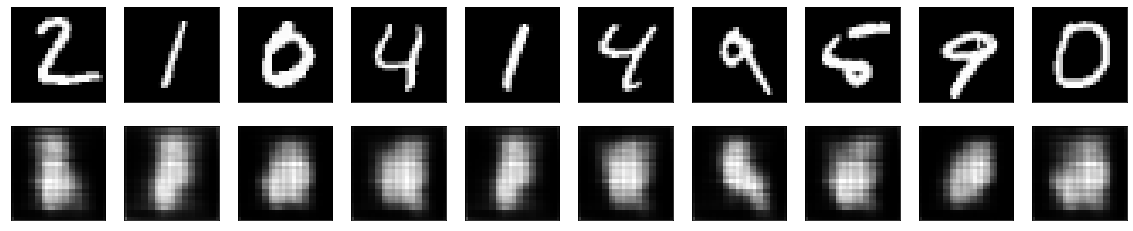

In [10]:
autoencoder.fit(x_train, x_train,
                epochs=10, # 50 is better
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_imgs = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # displaying the original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # displaying reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### References: 

   - https://www.jeremyjordan.me/autoencoders/
   - https://www.jeremyjordan.me/variational-autoencoders/
   - https://web.stanford.edu/class/cs294a/sparseAutoencoder_2011new.pdf
   - https://arxiv.org/pdf/1601.00670.pdf 
   - https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798
   - https://github.com/ardendertat/Applied-Deep-Learning-with-Keras/blob/master/notebooks/Part%203%20-%20Autoencoders.ipynb
   - https://stackoverflow.com/questions/62879232/how-do-i-use-latex-in-a-jupyter-notebook-inside-visual-studio-code 
   - https://blog.keras.io/building-autoencoders-in-keras.html 
   - https://towardsdatascience.com/autoencoders-bits-and-bytes-of-deep-learning-eaba376f23ad 
   - https://medium.com/ai%C2%B3-theory-practice-business/anomaly-detection-part-1-autoencoder-58bdbbea5001 
   - https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/
   - https://www.tensorflow.org/versions/r2.6/api_docs/python/tf/keras/layers/UpSampling2D
   - https://arxiv.org/abs/1211.4246 

dd